# Feature Extraction
* A common method of EEG classification encountered during research of literary sources was feature extraction. 
* Using the data points of the signals is not a good way to classify.
* However, extracting statistical, and signal processing related features may help significantly improve our classification results.
* There are over a hundred features that can be extracted from EEG based on the sources read.
* This notebook will try to explore a few of in the following realms:
    1. Statisical 
        * mean, median, std, skewness, kurtosis, max and min
    2. Time Domain
        * hjorth paramter, 1st difference mean and maximum
    3. Frequency Domain
        * Converting time domain signals into frequency domain signals with Fourier transform.
        * Caluclating band power and max power with FT.
    4. Wavelet-based features
        * Discrete Wavelet Transform (High pass and Low Pass)
    5. Auto-regressive Coefficients
        * AR model of order 6 using Burg's Algorithm. Using the coefficients as features.
* All of the feature domains will be explained further throughout the notebook.

Source: [S. S. R, J. Rabha, K. Y. Nagarjuna, D. Samanta, P. Mitra and M. Sarma, "Motor Imagery EEG Signal Processing and Classification Using Machine Learning Approach," 2017 International Conference on New Trends in Computing Sciences (ICTCS), Amman, 2017, pp. 61-66.
doi: 10.1109/ICTCS.2017.15](https://ieeexplore-ieee-org.ccny-proxy1.libr.ccny.cuny.edu/document/8250265/citations)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import time
import pickle
#need this to create pipeline for classification
from sklearn.pipeline import make_pipeline
#for scaling data into n_sample * n_feature array
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
#classifer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import mne
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                         cross_val_multiscore, LinearModel, get_coef, Vectorizer,CSP)
from mne.preprocessing import Xdawn
import os
import os.path as op
from os import listdir
from os.path import isfile, join
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'

#local path
path = 'C:\Users\Esimk\OneDrive\Desktop\eeg_data'

In [2]:
%run Functions.ipynb

In [ ]:
# subject_runs = get_subject_runs(path)
# filtered_epoch_files = get_filtered_epoch_files(subject_runs)


In [ ]:
# with open('filtered_epoch_files.pkl', 'w') as f:
#     pickle.dump(filtered_epoch_files, f)

In [3]:
with open('filtered_epoch_files.pkl', 'r') as f:
    files = np.array(pickle.load(f))

In [4]:
filtered_epoch_files = []
for f in files:
    filtered_epoch_files.append(f)

In [5]:
#get a random epoch file greater than 200 epochs
np.random.seed(42)
epoch_f = filtered_epoch_files[np.random.choice(len(filtered_epoch_files))]
print("epoch file name", epoch_f)
epochs = mne.read_epochs(epoch_f, preload=True)

('epoch file name', 'C:\\Users\\Esimk\\OneDrive\\Desktop\\eeg_data\\Ex10_Suj24_Run4-epo.fif')
Reading C:\Users\Esimk\OneDrive\Desktop\eeg_data\Ex10_Suj24_Run4-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
263 matching events found
Created an SSP operator (subspace dimension = 1)
263 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [6]:
# select channels near the visual cortex
epochs.pick_channels(['O1','O2','P7','P8'])

<EpochsFIF  |  n_events : 263 (all good), tmin : 0.0 (s), tmax : 1.4 (s), baseline : (0.0, 0.0), ~11.3 MB, data loaded,
 u'after': 66, u'before': 70, u'new': 67, u'scramble': 60>

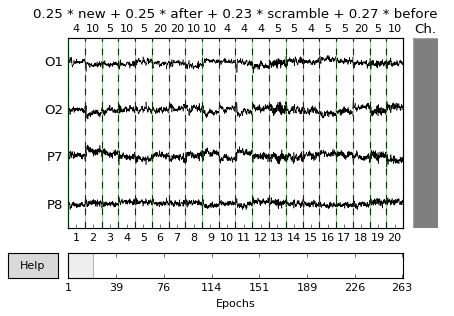

In [7]:
epochs.plot();

## Statistical Domain

In [8]:
def stat_of_epochs(epochs, stat):
    epoch_stats = np.empty(len(epochs))
    count = 0
    for i in range(len(epochs)):
        stats = np.empty(len(epochs.ch_names))
        for j in range(len(epochs.ch_names)):
            stats[j] = stat(epochs.get_data()[i,j,:])
            count +=1
        epoch_stats[i] = np.mean(stats)
    return epoch_stats

### Mean

In [9]:
mean = stat_of_epochs(epochs, np.mean)

### Standard Deviation

In [10]:
std = stat_of_epochs(epochs, np.std)

### Median

In [11]:
median = stat_of_epochs(epochs, np.median)

### Kurtosis

In [12]:
kurt = stat_of_epochs(epochs, stats.kurtosis)

### Skewness

In [13]:
skew = stat_of_epochs(epochs, stats.skew)

## Classification with these statistics

In [14]:
d = {'mean':mean, 'median':median,
     'std':std,'kurtosis': kurt, 
     'skewness':skew}
df = pd.DataFrame(data =d)
df['event'] = epochs.events[:,-1]
df.head()

,kurtosis,mean,median,skewness,std,event
0,1.859261,-1.614210e-07,-1.730476e-07,-0.519877,0.000007,4
1,0.560028,9.598730e-06,1.009916e-05,-0.390615,0.000009,10
2,0.803653,1.330149e-05,1.470093e-05,-0.678787,0.000009,5
3,0.503354,3.530241e-06,4.153588e-06,-0.614676,0.000007,10
4,-0.325227,9.036599e-06,8.541226e-06,-0.002977,0.000008,5


In [15]:
df_scram_new = df[(df.event == 5) | (df.event == 4)]
df_scram_new = df_scram_new.reset_index(drop=True)

In [80]:
val2 = df_scram_new['median'][df_scram_new['event'] == 4]
val2 = val2.values.reshape(-1,1)
sc = StandardScaler()
val2 = sc.fit_transform(val2)
# val2 = normalize(val2)
# val2

In [81]:
val1 = df_scram_new['std'][df_scram_new['event'] == 4]
val1 = val1.values.reshape(-1,1)
sc1 = StandardScaler()
val1 = sc1.fit_transform(val1)
# val1 = normalize(val1)

In [85]:
val3 = df_scram_new['median'][df_scram_new['event'] == 5]
val3 = val3.values.reshape(-1,1)
sc2 = StandardScaler()
val3 = sc2.fit_transform(val3)

In [86]:
val4 = df_scram_new['std'][df_scram_new['event'] == 5]
val4 = val4.values.reshape(-1,1)
sc3 = StandardScaler()
val4 = sc3.fit_transform(val4)

### Plotting Features

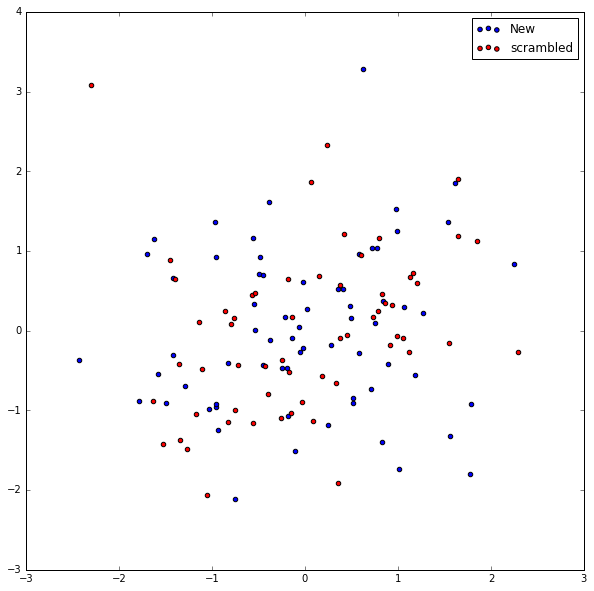

In [89]:
fig, ax = plt.subplots(figsize = (10,10))
# val1 = df_scram_new['mean'][df_scram_new['event'] == 4]
# val2 = df_scram_new['median'][df_scram_new['event'] == 4]
ax.scatter(val1, val2, c= 'b', label = 'New')
ax.scatter(val3, val4, c= 'r', label = 'scrambled')

# ax.scatter(df_scram_new['mean'][df_scram_new['event'] == 5], 
#            df_scram_new['std'][df_scram_new['event'] == 5], c= 'r', label = 'Scrambled')
ax.legend();

In [38]:
X = df_scram_new.iloc[:,:-1].values
y = df_scram_new.iloc[:,-1:].values

In [51]:
#normalize data
X = normalize(X)
y = y
X[:,0]

array([ 0.96306026,  0.76396145, -0.9999581 , -0.9174695 ,  0.80568399,
        0.23622605, -0.98523119, -0.73922606, -0.41775903, -0.78196888,
        0.74973135,  0.57655279,  0.33946765,  0.94288141,  0.79085455,
       -0.38518961, -0.56547869, -0.8283962 ,  0.64504306,  0.98779051,
        0.92889002,  0.8890289 , -0.44481051, -0.99430145, -0.37430005,
       -0.99646497, -0.77697715, -0.97012804, -0.70365703, -0.92383798,
        0.35663679,  0.214977  ,  0.88400141, -0.18219266, -0.85276191,
       -0.88619463,  0.54723749,  0.80657146,  0.13324665,  0.31192725,
       -0.95887879, -0.9852764 , -0.63065843, -0.99772171,  0.30684168,
       -0.74031602,  0.37707971,  0.18963062, -0.77145626, -0.99770431,
        0.53366573, -0.35478599,  0.9070486 ,  0.96035047,  0.16358059,
       -0.571724  , -0.59282864,  0.28150646, -0.96990322,  0.21509239,
       -0.34483217, -0.92551197, -0.61133205, -0.99691287, -0.98809067,
       -0.98395049, -0.91453796,  0.98582057, -0.70599047, -0.19

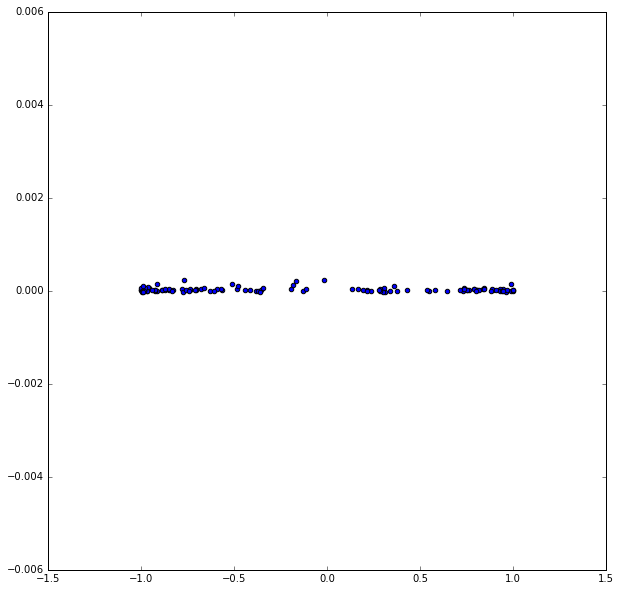

In [53]:
fig, ax = plt.subplots(figsize = (10,10))

ax.scatter(X[:,0],X[:,1] );


In [263]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .30, random_state = 42)
clf = make_pipeline(StandardScaler(), LogisticRegression())


In [264]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [265]:
clf.score(X_test, y_test)

0.53846153846153844

In [266]:
X.shape

(127L, 5L)